<a href="https://colab.research.google.com/github/shilpamatne/FDP_AdiSankara/blob/main/9_ConvAutoencoder_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you have a whole bunch of normal images and anomaly image, the task is easy. its a binary classification. but if you have only normal images??

Anything thats not normal is to be interpreted as anomaly.

Using autoencoders. If the reconstruction error is grater than  a particular threshold, its an anomaly.
Taking a vgg , putting a mirror reflection
Encoder( taking a larger image and transforming to a smaller     

In [ ]:

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
! unzip '/content/drive/MyDrive/Malaria_dataset.zip' -d '/content/Malaria_datasett/'

In [ ]:

#Size of our input images
SIZE = 128

In [ ]:
#Define generators for training, validation and also anomaly data.

batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)#,rotation_range = 5, shear_range = 0.02,\
                             #zoom_range = 0.02, samplewise_center=True, \
                             #samplewise_std_normalization= True)

train_generator = datagen.flow_from_directory(
    '/content/Malaria_datasett/Malaria dataset/Uninfected_train/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    '/content/Malaria_datasett/Malaria dataset/Uninfected_val/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    '/content/Malaria_datasett/Malaria dataset/Infected/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


Found 132 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 60 images belonging to 1 classes.


In [ ]:
#Define the autoencoder. 
#Try to make the bottleneck layer size as small as possible to make it easy for
#density calculations and also picking appropriate thresholds. 

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [ ]:
#Fit the model. 
history = model.fit(
        train_generator,
        
        epochs=1000,
        validation_data=validation_generator,
        
        shuffle = True)


Epoch 1/1000
3/3 [==============================] - 6s 576ms/step - loss: 0.0935 - mse: 0.0935 - val_loss: 0.0939 - val_mse: 0.0939
Epoch 2/1000
3/3 [==============================] - 0s 166ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0810 - val_mse: 0.0810
Epoch 3/1000
3/3 [==============================] - 0s 123ms/step - loss: 0.0724 - mse: 0.0724 - val_loss: 0.0677 - val_mse: 0.0677
Epoch 4/1000
3/3 [==============================] - 0s 122ms/step - loss: 0.0590 - mse: 0.0590 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 5/1000
3/3 [==============================] - 0s 161ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 6/1000
3/3 [==============================] - 0s 166ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 7/1000
3/3 [==============================] - 0s 94ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 8/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.02

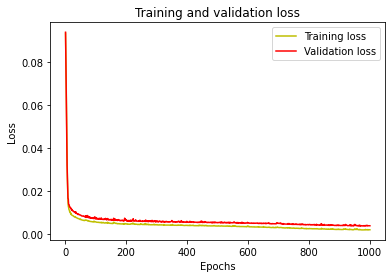

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#pretty good training.. so we must be able to reconstruct well. 

Lets get a batch of images. We have used DataGenrator, how it generates a batch of images? using .next()

At the end of this, I will have all my batches. Each batch will contain 64 items. 

In [ ]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

print(len(data_batch))


3


From the list containing batches, we pick firts batch and do predictions. 

In [ ]:
predicted = model.predict(data_batch[0])  #Predict on the first batch of images


2/2 [==============================] - 0s 20ms/step


Now going to predict on some random images

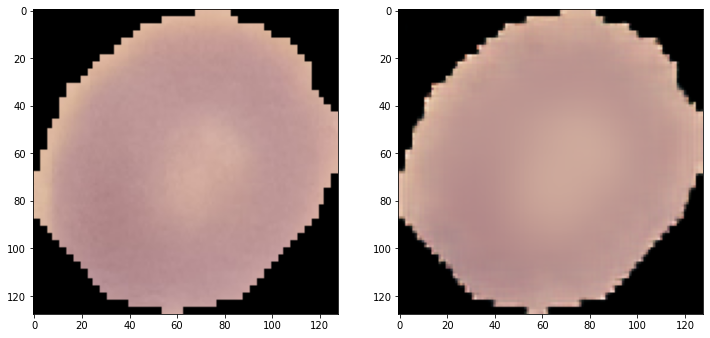

In [ ]:
#view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

Evaluating on validation data and anomaly data. 

There s a diffreence between the two errors. Thats a good sign. 

In [ ]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

1/1 [==============================] - 0s 133ms/step - loss: 0.0063 - mse: 0.0063
Recon. error for the validation (normal) data is:  [0.003782518906518817, 0.003782518906518817]
Recon. error for the anomaly data is:  [0.006325551308691502, 0.006325551308691502]


For Kernel density estimation, we neeed the encoder part

In [ ]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
#this populates it with the weights that have been learned during the training tme
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

# we are not training the model here, just  going to use the weights as the feature generator or the latent vector generator

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

To generate latent vector representation of training/ good data, we use predict_generator on the enccoder model. 

In [ ]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity #KD applies on 1D data. 

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator) # train_generaor indicates training set 

# this egenrates latent vectors, whcih you can use to get kernel density


3/3 [==============================] - 0s 42ms/step


In [ ]:
# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3] #16*16*16= 4096

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

In [ ]:
#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

To set a threshold on reconstruction error and KD, we need to see what these values are for our normal images. For that, we have this function

In [ ]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    print(average_density, stdev_density, average_recon_error, stdev_recon_error)
    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [ ]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]
print("Uninfected")
uninfected_values = calc_density_and_recon_error(train_batch)
print("anomaly")
anomaly_values = calc_density_and_recon_error(anomaly_batch)



Uninfected
1/1 [==============================] - 0s 21ms/step - loss: 0.0064 - mse: 0.0064
2823.40265540115 4.547473508864641e-13 0.003685244137332553 0.0009690850541293792
anomaly
1/1 [==============================] - 0s 20ms/step - loss: 0.0183 - mse: 0.0183
-2504.6829182451374 3021.75225108146 0.00907336488381912 0.0038600109187024918


In [ ]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.006 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
        

In [ ]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('/content/Malaria_datasett/Malaria dataset/Infected/images/*')
uninfected_file_paths = glob.glob('/content/Malaria_datasett/Malaria dataset/Uninfected_train/images/*')


1/1 [==============================] - 0s 17ms/step - loss: 0.0044 - mse: 0.0044
The image is an anomaly


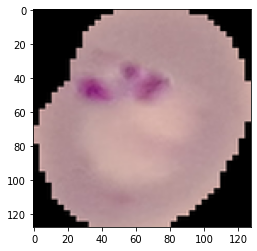

In [ ]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])


1/1 [==============================] - 0s 17ms/step - loss: 0.0039 - mse: 0.0039
The image is NOT an anomaly


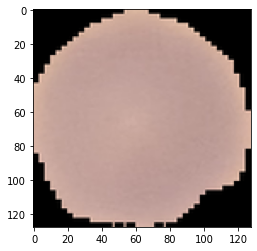

In [ ]:
#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])

#Only considering reconstruction error

In [ ]:
def check_anomaly(img_path):
    
    reconstruction_error_threshold = 0.0045 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    #encoded_img = encoder_model.predict([[img]]) 
    #encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    #density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
        

In [ ]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('/content/Malaria_datasett/Malaria dataset/Infected/images/*')
uninfected_file_paths = glob.glob('/content/Malaria_datasett/Malaria dataset/Uninfected_train/images/*')


1/1 [==============================] - 0s 17ms/step - loss: 0.0044 - mse: 0.0044
The image is NOT an anomaly


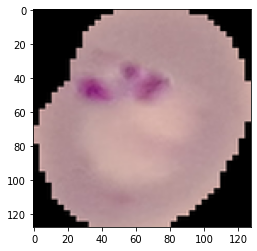

In [ ]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

1/1 [==============================] - 0s 19ms/step - loss: 0.0039 - mse: 0.0039
The image is NOT an anomaly


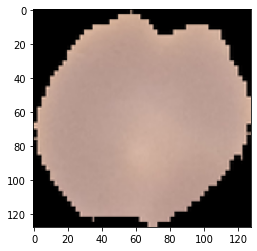

In [ ]:
#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])